**Generative Adversarial Networks**


In [ ]:
import torch
import torch.nn as nn
nz = 100
ngf = 128
ndf = 128
nc = 3

class generator(nn.Module):
    def __init__(self, ngpu):
        super(generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

class discriminator(nn.Module):
    def __init__(self, ngpu):
        super(discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Import necessary libraries to create a generative adversarial network
The code is mainly developed using the PyTorch library
"""
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import transforms
from model import discriminator, generator
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import tensorflow as tf
torch.cuda.empty_cache()


"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class tekeningDataset(Dataset):
      def __init__(self, X):
          self.X = X

      def __len__(self):
          return len(self.X)

      def __getitem__(self, index):
        'Generates one sample of data'
        image = self.X[index]
        X = self.transform(image)
        X = X.float()
        return X
    
        transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

"""
Hyperparameter settings
"""
epochs = 150
lr = 2e-4
# batch_size = 64
loss = nn.BCELoss()
size = 128

# Model
G = generator().to(device)
# G.apply(weights_init)
D = discriminator().to(device)
# D.apply(weights_init)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


"""
Image transformation and dataloader creation
Note that we are training generation and not classification, and hence
only the train_loader is loaded
"""
# Transform
transform = transforms.Compose([transforms.ToTensor()])
# # Load data
# train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# print(train_set[0].shape())

# DATA_DIR = r"/content/drive/MyDrive/GAN files/dataset_multiplied.npy"
DATA_DIR = r'/content/flower_dataset.npy'
X_train = np.load(DATA_DIR, allow_pickle=True)
# print(X_train.shape)
X_train_final = []
# for x in X_train:
#     X_train_final.append()
print(X_train.shape)
# X_train_final = transform(X_train)
# t = 0
for x in X_train:
    if t % 1 == 0:
        X_train_final.append(transform(x))
    t += 1

# X_train_transformed = tekeningDataset(X_train)


(1200,)


In [ ]:
mnist, x = tf.keras.datasets.mnist.load_data()
X_train_final = mnist
print(mnist)

In [ ]:
"""
Import necessary libraries to create a generative adversarial network
The code is mainly developed using the PyTorch library
"""
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import transforms
from model import discriminator, generator
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import tensorflow as tf
torch.cuda.empty_cache()

epochs = 150
batch_size = 250
train_loader = DataLoader(X_train_final, batch_size=batch_size, shuffle=True)

"""
Network training procedure
Every step both the loss for disciminator and generator is updated
Discriminator aims to classify reals and fakes
Generator aims to generate images as realistic as possible
"""
for epoch in range(epochs):
    for idx, (imgs) in enumerate(train_loader):
        idx += 1

        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = imgs.to(device)   
        real_outputs = D(real_inputs).view(-1)
        real_label = torch.ones(real_outputs.shape[0], 1).to(device)
        real_cpu = imgs[0].to(device)
        b_size = real_cpu.size(0)
        noise = (torch.rand(128) - 0.5) / 0.5
        # noise = torch.randn(b_size, nz, 1, 1, device=device)
        noise = noise.to(device)
        # print(noise.shape)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs).view(-1)
        fake_label = torch.zeros(fake_outputs.shape[0], 1).to(device)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)

        # print("Realin = {}     Fakein = {}".format(real_inputs.size(), fake_inputs.size()))

        # outputs = outputs.squeeze(1)
        targets = targets.squeeze(1)

        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()                               ##Set gradient to 0 (was accumulated from previous step)
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        # noise = (torch.rand(real_inputs.shape[0], size)-0.5)/0.5
        # noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_outputs.shape[0], 1]).to(device)
        fake_outputs = fake_outputs.squeeze(1)
        fake_targets = fake_targets.squeeze(1)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

RuntimeError: ignored

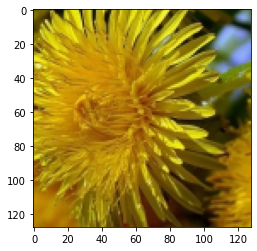

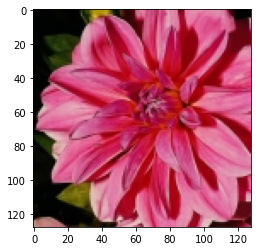

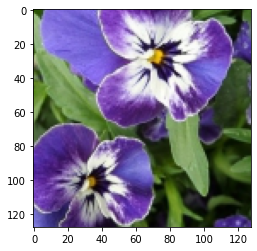

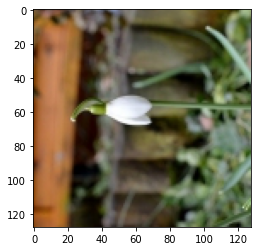

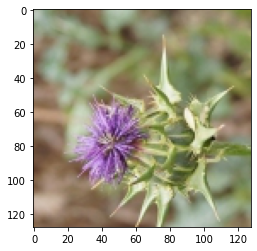

In [ ]:
from torchvision.utils import make_grid
%matplotlib inline 

def show_images(images, nmax=64):
    plt.imshow(images.T)
    plt.show()

def show_batch(dl, nmax=64):
    i = 0
    for images in dl:
        if i < nmax:
            show_images(images, nmax)
            i += 1
show_batch(X_train_final, 5)

9
(3, 128, 128)


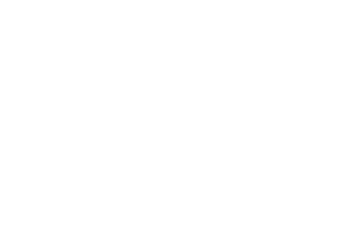

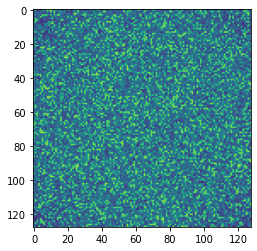

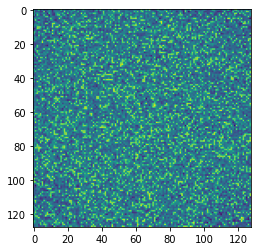

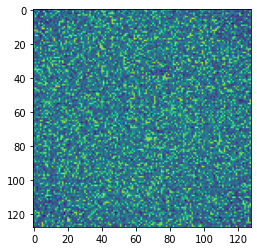

In [ ]:
import torch
import numpy as np

noise = (torch.rand(size)-0.5)/0.5
# noise = torch.randn(b_size, nz, 1, 1, device=device)
noise = noise.to(device)


transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Normalize((0.5,), (0.5,))])
amount = 1
epochs = 10
for n in range(amount):
  G_number = (epochs - 1)  - (amount - n) * 10 + 10
  G = torch.load("Generator_epoch_{}.pth".format(G_number))
  print(G_number)
  noise = (torch.rand(size)-0.5)/0.5
  noise = noise.to(device)

  image = G(noise)
  image = image.cpu()
  image = image.detach().numpy()
  image = image.squeeze()  
  
  print(image.shape)
  plt.axis('off')
  plt.figure()
  
#   plt.imshow(np.transpose(image[0]))
  show_batch(image, 5)
#   plt.imshow(np.squeeze(image.T))

plt.show()

